In [39]:
%pip install wordcloud
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 1.8 MB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [28]:
#Importing required libraries
import pandas as pd, numpy as np
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import unicodedata
from collections import Counter
import os, re
import time

#Import libraries for plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
#Function for data cleaning 
def data_cleaning(tweets_data):
    clean_tweets = []
    token = TweetTokenizer()
    tweet_st= ''
   
    for tweet in tweets_data:
        #Covert all the tweets to lowercase
        tweet = tweet.lower()
        #Remove user handle from a tweet
        tweet = re.sub("@\w+","", tweet)
        #Remove url from a tweet
        tweet = re.sub("\w+://\S+","", tweet)
        #Remove non-alphanumeric characters from a tweet
        tweet = re.sub('[^a-zA-z0-9\s]', '', tweet)
        #Remove accent characters from a tweet
        tweet = unicodedata.normalize('NFKD', tweet).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        
        #Tokenize each tweet
        tweet = token.tokenize(tweet)
               
        #Removing stop words
        tweets_no_stop_words = remove_stop_words(tweet)
            
        #Lemmatizing each tweet 
        lemm_tweets = lemmatize_data(tweets_no_stop_words)
        clean_tweets.append(lemm_tweets)
    return clean_tweets

In [3]:
#Function for lemmatization
def lemmatize_data(tweet):
    lemma =[]
    lemmatizer = WordNetLemmatizer()
    for word in tweet:
        lemma.append(lemmatizer.lemmatize(word))
    return lemma

In [4]:
#Function to remove stop words
def remove_stop_words(tweet):
    stop_nltk = stopwords.words("english")
    stop_punct = list(punctuation)
    #Set a list of stop words that doesn't need to be processed
    stop_punct.extend(['...','``',"''",".."])
    stop_context = ['rt', 'amp']
    #Remove a few important words from stopwords 
    remove_stop = ['not','nobody','nor','no']
    stop_modified = [stwrd for stwrd in stop_nltk if stwrd not in remove_stop]
    stop_final = stop_modified + stop_punct + stop_context
    tweet = [word for word in tweet if word not in stop_final]
    return tweet

In [5]:
#Function to get the most common words in the tweets
def most_common_words(tweets):
    comm_words = []
    term_list =[]
    for tweet in tweets:
        term_list.extend(tweet)
    res = Counter(term_list)
    for word in res.most_common(1000):
        comm_words.append(word[0])
    return comm_words

In [6]:
#Function to plot word cloud
def plot_word_cloud(tweets):
    plt.figure(figsize = (10,10))
    wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,relative_scaling=1,
               collocations=False).generate(" ".join(tweets))
    plt.imshow(wc,interpolation='bilinear')
    

In [7]:
# Accuracy Function
def Evaluate_model(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [9]:
#Read the dataset
col_names  = ["sentiment", "ids", "date", "flag", "user", "text"]
twitter_data = pd.read_csv("twitter_data.csv", names=col_names)
twitter_data = twitter_data[['sentiment','text']]

twitter_data['sentiment'] = twitter_data['sentiment'].replace(0,1)
twitter_data['sentiment'] = twitter_data['sentiment'].replace(4,0)



In [10]:
#Trim the original dataset
neg_data = twitter_data[twitter_data['sentiment'] == 1][:300000]
pos_data = twitter_data[twitter_data['sentiment'] == 0][:300000]
print("legth of negative sentiments.", len(neg_data))
print("legth of positive sentiments.", len(pos_data))
twitter_data = pd.concat([neg_data, pos_data])

legth of negative sentiments. 300000
legth of positive sentiments. 300000


0    300000
1    300000
Name: sentiment, dtype: int64


[Text(0, 0, 'Positive'), Text(1, 0, 'Negative')]

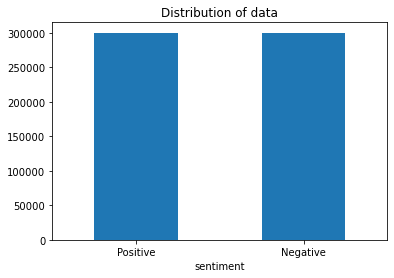

In [11]:
#Count the no. of records of each class
print(twitter_data.sentiment.value_counts())

#Visualize each category
ax = twitter_data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Positive','Negative'], rotation=0)

In [12]:
# Storing data in lists.
twitter_data = twitter_data.sort_values(by=['sentiment'])

tweets, sentiment = list(twitter_data['text']), list(twitter_data['sentiment'])

#Check how many tweets we have got
print(len(tweets))

#Get first five tweets to decide what needs to be done for data cleaning
tweets[:5]

600000


["YAY!! It's Saturday. Going to Brad &amp; Meg's for Cindy's (5/24) &amp; Zach's (6/2) birthday celebrations!! Let the Birthday Parties begin!! ",
 '@jvdouglas  haha, no, the remark on maternity leave fired me up a little ',
 '@altitis and to you! ',
 "Okie doke!! Time for me to escape for the North while Massa's back is turned. Be on when I get home folks ",
 'finished the lessons, hooray! ']

In [13]:
#Preprocessing tweets text
start_time = time.time()
cleaned_tweets = data_cleaning(tweets)
end_time = time.time()
print("time taken to process: ", end_time - start_time)


time taken to process:  102.96677684783936


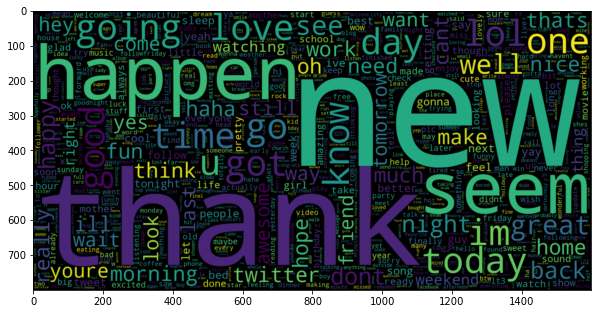

In [14]:
#Word cloud for most common positive words
pos_tweets = cleaned_tweets[:300000]
com_words_pos_tweets = most_common_words(pos_tweets)
plot_word_cloud(com_words_pos_tweets)

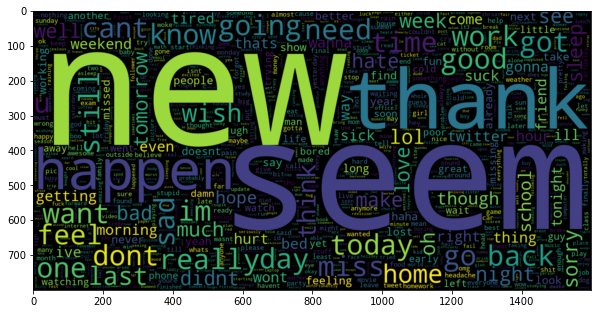

In [15]:
#Word cloud for most common negative words
neg_tweets = cleaned_tweets[300000:]
com_words_neg_tweets = most_common_words(neg_tweets)
plot_word_cloud(com_words_neg_tweets)

In [16]:
#Convert the cleaned tweets data into strings
tweet_str = [" ".join(tweet) for tweet in cleaned_tweets]
tweet_str
print(len(tweet_str))

600000


In [17]:
#Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweet_str, sentiment, stratify=sentiment, 
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')
print(len(X_train))

Data Split done.
480000


In [18]:
#Tf-idf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
start_time = time.time()
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_sparse = vectoriser.fit_transform(X_train)
X_test_sparse  = vectoriser.transform(X_test)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))
end_time = time.time()
print("Time taken to vectorize the data is: ", end_time - start_time)

Vectoriser fitted.
No. of feature_words:  10000
Time taken to vectorize the data is:  10.644203901290894


In [19]:
#TruncatedSVD method
from sklearn.decomposition import TruncatedSVD
start_time = time.time()
svd = TruncatedSVD(n_components=300, random_state=42)
X_train = svd.fit_transform(X_train_sparse) 
X_test = svd.transform(X_test_sparse)
print(svd.explained_variance_ratio_.sum())
print(f'Data Transformed.')
end_time = time.time()
print("Time taken to run truncatedSVD is: ", end_time - start_time)

0.3262681030165665
Data Transformed.
Time taken to run truncatedSVD is:  59.49781012535095


In [20]:
#Train BernoulliNB
from sklearn.naive_bayes import BernoulliNB
start_time = time.time()
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
print("Trained the model")
end_time = time.time()
print("Time taken to run BernoulliNB is: ", end_time - start_time)

Trained the model
Time taken to run BernoulliNB is:  1.9879391193389893


              precision    recall  f1-score   support

           0       0.66      0.65      0.65     60000
           1       0.66      0.67      0.66     60000

    accuracy                           0.66    120000
   macro avg       0.66      0.66      0.66    120000
weighted avg       0.66      0.66      0.66    120000



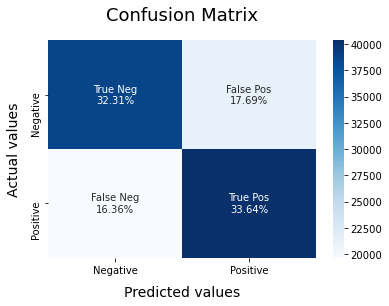

In [21]:
#Prediction and confusion matrix of BernoulliNB
Evaluate_model(BNBmodel)

AUC for Bernoulli Naive Bayes: 0.7194413705555556


Text(0, 0.5, 'TPR')

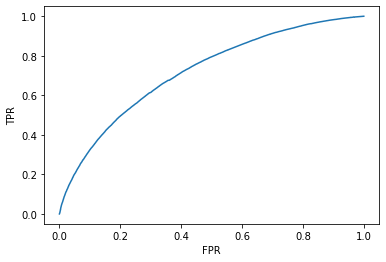

In [32]:
# ROC Curve for Bernoulli Naive Bayes
proba = BNBmodel.predict_proba(X_test)[:, 1]
print("AUC for Bernoulli Naive Bayes:", roc_auc_score(y_test, proba))

fpr, tpr, threshold = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [22]:
#Train Decision tree model
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()
tree_3 = DecisionTreeClassifier(random_state = 0, criterion = 'entropy', max_depth = 8)
tree_3.fit(X_train, y_train)
end_time = time.time()
print("Time taken to run decision tree model is: ", end_time - start_time)

Time taken to run decision tree model is:  141.96923184394836


              precision    recall  f1-score   support

           0       0.70      0.60      0.65     60000
           1       0.65      0.74      0.69     60000

    accuracy                           0.67    120000
   macro avg       0.67      0.67      0.67    120000
weighted avg       0.67      0.67      0.67    120000



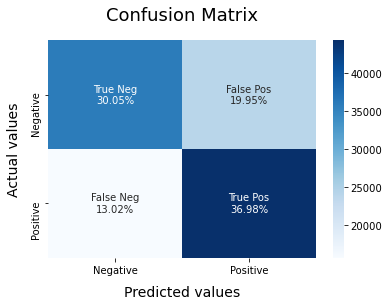

In [23]:
#Prediction and confusion matrix of Decision tree
Evaluate_model(tree_3)

AUC for Decision Trees: 0.7430686826388888


Text(0, 0.5, 'TPR')

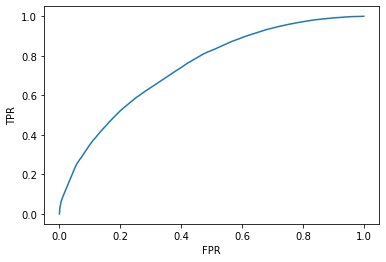

In [37]:
# ROC Curve for Bernoulli Naive Bayes
proba = tree_3.predict_proba(X_test)[:, 1]
print("AUC for Decision Trees:", roc_auc_score(y_test, proba))

fpr, tpr, threshold = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [24]:
#Train random-forest
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
rnd_clf = RandomForestClassifier(n_estimators=200, max_samples=800, random_state=42, min_samples_split= 10, max_depth=10)
rnd_clf.fit(X_train, y_train)
end_time = time.time()
print("Time taken to run random forest is: ", end_time - start_time)

Time taken to run random forest is:  7.985084295272827


              precision    recall  f1-score   support

           0       0.71      0.66      0.69     60000
           1       0.69      0.73      0.71     60000

    accuracy                           0.70    120000
   macro avg       0.70      0.70      0.70    120000
weighted avg       0.70      0.70      0.70    120000



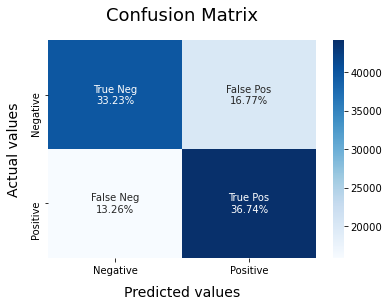

In [25]:
#Prediction and confusion matrix of Random forest
Evaluate_model(rnd_clf)

AUC for Random Forest: 0.76845196375


Text(0, 0.5, 'TPR')

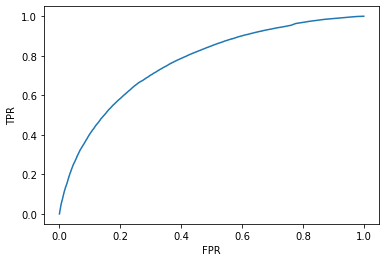

In [35]:
# ROC Curve for Random Forest
proba = rnd_clf.predict_proba(X_test)[:, 1]
print("AUC for Random Forest:", roc_auc_score(y_test, proba))

fpr, tpr, threshold = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [26]:
#Train logistic model
from sklearn.linear_model import LogisticRegression

start_time = time.time()
logreg = LogisticRegression(C = 2, max_iter = 1000, n_jobs=2)
logreg.fit(X_train, y_train)
end_time = time.time()
print("Time taken to run logistic model is: ", end_time - start_time)

Time taken to run logistic model is:  168.438805103302


              precision    recall  f1-score   support

           0       0.72      0.77      0.75     60000
           1       0.76      0.70      0.73     60000

    accuracy                           0.74    120000
   macro avg       0.74      0.74      0.74    120000
weighted avg       0.74      0.74      0.74    120000



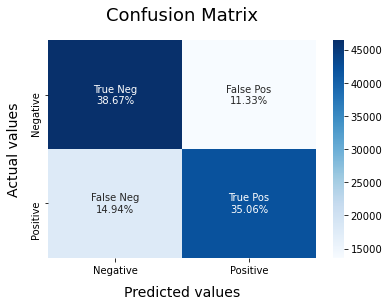

In [27]:
#Prediction and confusion matrix of logistic regression
Evaluate_model(logreg)

AUC for Logistic Regression: 0.8170195909722222


Text(0, 0.5, 'TPR')

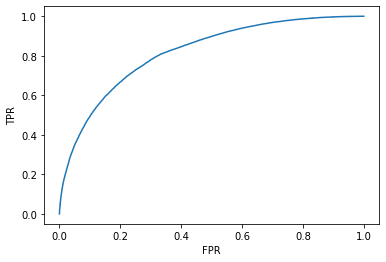

In [34]:
# ROC Curve for Logistic Regression
proba = logreg.predict_proba(X_test)[:, 1]
print("AUC for Logistic Regression:", roc_auc_score(y_test, proba))

fpr, tpr, threshold = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [40]:
#Train XGBoost Classifier model
from xgboost import XGBClassifier

start_time = time.time()
xgb_m = XGBClassifier()
xgb_m.fit(X_train, y_train)
end_time = time.time()
print("Time taken to run logistic model is: ", end_time - start_time)

Time taken to run logistic model is:  496.5797429084778


              precision    recall  f1-score   support

           0       0.74      0.75      0.75     60000
           1       0.75      0.74      0.75     60000

    accuracy                           0.75    120000
   macro avg       0.75      0.75      0.75    120000
weighted avg       0.75      0.75      0.75    120000



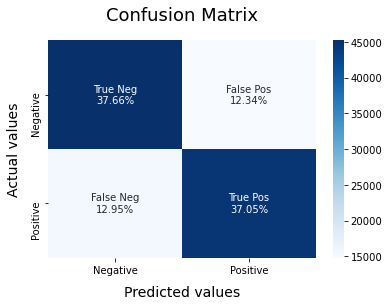

In [41]:
#Prediction and confusion matrix of logistic regression
Evaluate_model(xgb_m)

AUC for XGBoost Classifier: 0.8281189727777777


Text(0, 0.5, 'TPR')

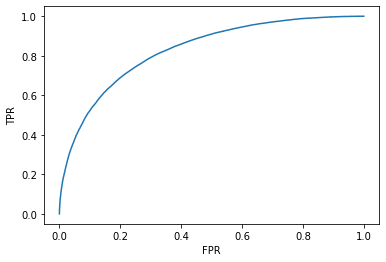

In [42]:
# ROC Curve for XGBoost Classifier
proba = xgb_m.predict_proba(X_test)[:, 1]
print("AUC for XGBoost Classifier:", roc_auc_score(y_test, proba))

fpr, tpr, threshold = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')